<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/notebooks/transfer_learning_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [18]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.9.0+cu126
Using device: cuda:0


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}


In [21]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True if x=="train" else False, num_workers=2, persistent_workers=False)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


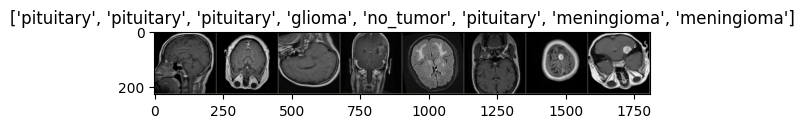

In [22]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [23]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")


Total params: 11178564
Total Trainable Parameters: 2052


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [25]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [26]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [27]:
NUM_EPOCHS = 50
best_val_acc = 0.0
best_model_path = 'resnet18_clsf_head.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

    # if early_stopper.early_stop:
    #     print("Early stopping triggered.")
    #     break


total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/50


    train_loss: 0.8843    train_acc: 0.6602
    val_loss: 0.5498    val_acc: 0.8008
Saved new best model
Epoch 2/50


    train_loss: 0.6413    train_acc: 0.7587
    val_loss: 0.5316    val_acc: 0.7928
Epoch 3/50


    train_loss: 0.5641    train_acc: 0.7894
    val_loss: 0.4308    val_acc: 0.8526
Saved new best model
Epoch 4/50


    train_loss: 0.5303    train_acc: 0.7971
    val_loss: 0.4004    val_acc: 0.8526
Epoch 5/50


    train_loss: 0.5644    train_acc: 0.7906
    val_loss: 0.4127    val_acc: 0.8446
Epoch 6/50


    train_loss: 0.5190    train_acc: 0.7959
    val_loss: 0.4064    val_acc: 0.8665
Saved new best model
Epoch 7/50


    train_loss: 0.4960    train_acc: 0.8124
    val_loss: 0.4151    val_acc: 0.8486
Epoch 8/50


    train_loss: 0.4791    train_acc: 0.8218
    val_loss: 0.4255    val_acc: 0.8426
Epoch 9/50


    train_loss: 0.4869    train_acc: 0.8147
    val_loss: 0.4018    val_acc: 0.8625
Epoch 10/50


    train_loss: 0.4775    train_acc: 0.8136
    val_loss: 0.3500    val_acc: 0.8865
Saved new best model
Epoch 11/50


    train_loss: 0.4740    train_acc: 0.8071
    val_loss: 0.3846    val_acc: 0.8526
Epoch 12/50


    train_loss: 0.4486    train_acc: 0.8336
    val_loss: 0.3673    val_acc: 0.8665
Epoch 13/50


    train_loss: 0.4534    train_acc: 0.8248
    val_loss: 0.3669    val_acc: 0.8645
Epoch 14/50


    train_loss: 0.4376    train_acc: 0.8389
    val_loss: 0.3530    val_acc: 0.8825
Epoch 15/50


    train_loss: 0.4277    train_acc: 0.8383
    val_loss: 0.4072    val_acc: 0.8625
Epoch 16/50


    train_loss: 0.4302    train_acc: 0.8437
    val_loss: 0.3859    val_acc: 0.8625
Epoch 17/50


    train_loss: 0.4318    train_acc: 0.8366
    val_loss: 0.3310    val_acc: 0.8924
Saved new best model
Epoch 18/50


    train_loss: 0.4363    train_acc: 0.8389
    val_loss: 0.3352    val_acc: 0.8944
Saved new best model
Epoch 19/50


    train_loss: 0.4319    train_acc: 0.8313
    val_loss: 0.3222    val_acc: 0.8944
Epoch 20/50


    train_loss: 0.4192    train_acc: 0.8490
    val_loss: 0.3353    val_acc: 0.8884
Epoch 21/50


    train_loss: 0.4263    train_acc: 0.8413
    val_loss: 0.3246    val_acc: 0.8884
Epoch 22/50


    train_loss: 0.4170    train_acc: 0.8531
    val_loss: 0.3364    val_acc: 0.8884
Epoch 23/50


    train_loss: 0.4239    train_acc: 0.8372
    val_loss: 0.3340    val_acc: 0.8865
Epoch 24/50


    train_loss: 0.4161    train_acc: 0.8466
    val_loss: 0.3454    val_acc: 0.8825
Epoch 25/50


    train_loss: 0.4117    train_acc: 0.8484
    val_loss: 0.3317    val_acc: 0.8884
Epoch 26/50


    train_loss: 0.4393    train_acc: 0.8289
    val_loss: 0.3500    val_acc: 0.8805
Epoch 27/50


    train_loss: 0.4006    train_acc: 0.8537
    val_loss: 0.3307    val_acc: 0.8845
Epoch 28/50


    train_loss: 0.4396    train_acc: 0.8425
    val_loss: 0.3270    val_acc: 0.8825
Epoch 29/50


    train_loss: 0.4434    train_acc: 0.8277
    val_loss: 0.3407    val_acc: 0.8825
Epoch 30/50


    train_loss: 0.3979    train_acc: 0.8537
    val_loss: 0.3502    val_acc: 0.8745
Epoch 31/50


    train_loss: 0.4316    train_acc: 0.8395
    val_loss: 0.3375    val_acc: 0.8865
Epoch 32/50


    train_loss: 0.4086    train_acc: 0.8543
    val_loss: 0.3404    val_acc: 0.8805
Epoch 33/50


    train_loss: 0.4134    train_acc: 0.8543
    val_loss: 0.3257    val_acc: 0.8904
Epoch 34/50


    train_loss: 0.3954    train_acc: 0.8466
    val_loss: 0.3314    val_acc: 0.8865
Epoch 35/50


    train_loss: 0.3751    train_acc: 0.8667
    val_loss: 0.3454    val_acc: 0.8865
Epoch 36/50


    train_loss: 0.4179    train_acc: 0.8448
    val_loss: 0.3435    val_acc: 0.8805
Epoch 37/50


    train_loss: 0.4013    train_acc: 0.8501
    val_loss: 0.3367    val_acc: 0.8825
Epoch 38/50


    train_loss: 0.3918    train_acc: 0.8566
    val_loss: 0.3558    val_acc: 0.8845
Epoch 39/50


    train_loss: 0.4259    train_acc: 0.8501
    val_loss: 0.3182    val_acc: 0.9024
Saved new best model
Epoch 40/50


    train_loss: 0.4148    train_acc: 0.8442
    val_loss: 0.3540    val_acc: 0.8785
Epoch 41/50


    train_loss: 0.4041    train_acc: 0.8560
    val_loss: 0.3421    val_acc: 0.8845
Epoch 42/50


    train_loss: 0.4083    train_acc: 0.8484
    val_loss: 0.3451    val_acc: 0.8865
Epoch 43/50


    train_loss: 0.4234    train_acc: 0.8425
    val_loss: 0.3406    val_acc: 0.8705
Epoch 44/50


    train_loss: 0.4189    train_acc: 0.8431
    val_loss: 0.3285    val_acc: 0.8884
Epoch 45/50


    train_loss: 0.4099    train_acc: 0.8484
    val_loss: 0.3230    val_acc: 0.8944
Epoch 46/50


    train_loss: 0.4208    train_acc: 0.8378
    val_loss: 0.3172    val_acc: 0.8964
Epoch 47/50


    train_loss: 0.4125    train_acc: 0.8490
    val_loss: 0.3201    val_acc: 0.8964
Epoch 48/50


    train_loss: 0.4139    train_acc: 0.8602
    val_loss: 0.3422    val_acc: 0.8785
Epoch 49/50


    train_loss: 0.4119    train_acc: 0.8496
    val_loss: 0.3615    val_acc: 0.8765
Epoch 50/50


    train_loss: 0.4250    train_acc: 0.8460
    val_loss: 0.3475    val_acc: 0.8805
Training Complete in 21.56 minutes. Best val acc: 0.9024'


Final validation loss: 0.3182, acc: 0.9024
Confusion Matrix:
 [[155   6   0   0]
 [  7  99  10   8]
 [  4   4  90   1]
 [  1   7   1 109]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9281    0.9627    0.9451       161
  meningioma     0.8534    0.7984    0.8250       124
    no_tumor     0.8911    0.9091    0.9000        99
   pituitary     0.9237    0.9237    0.9237       118

    accuracy                         0.9024       502
   macro avg     0.8991    0.8985    0.8985       502
weighted avg     0.9013    0.9024    0.9015       502



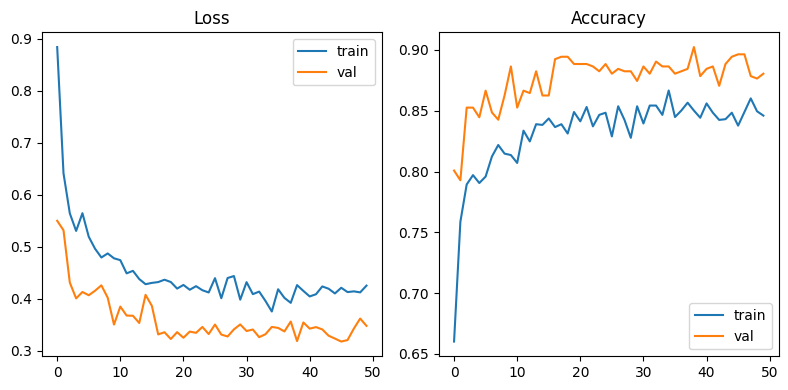

In [28]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()

In [29]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


In [33]:
checkpoint = torch.load('/content/resnet18_clsf_head.h5', map_location=device)
model.load_state_dict(checkpoint['model_state'])

for param in model.parameters():
    param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-5, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
print("Now fine-tuning full model...")

NUM_EPOCHS = 60   # tried 20, 30 and 60
best_val_acc = 0.0
best_model_path = 'finetuned_resnet18.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

    # if early_stopper.early_stop:
    #     print("Early stopping triggered.")
    #     break


total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Now fine-tuning full model...
Epoch 1/60


    train_loss: 0.3957    train_acc: 0.8519
    val_loss: 0.2518    val_acc: 0.9323
Saved new best model
Epoch 2/60


    train_loss: 0.3205    train_acc: 0.8968
    val_loss: 0.2201    val_acc: 0.9402
Saved new best model
Epoch 3/60


    train_loss: 0.2686    train_acc: 0.9068
    val_loss: 0.2078    val_acc: 0.9422
Saved new best model
Epoch 4/60


    train_loss: 0.2177    train_acc: 0.9215
    val_loss: 0.2044    val_acc: 0.9323
Epoch 5/60


    train_loss: 0.2204    train_acc: 0.9215
    val_loss: 0.1654    val_acc: 0.9562
Saved new best model
Epoch 6/60


    train_loss: 0.1981    train_acc: 0.9316
    val_loss: 0.1510    val_acc: 0.9562
Epoch 7/60


    train_loss: 0.1689    train_acc: 0.9469
    val_loss: 0.1468    val_acc: 0.9562
Epoch 8/60


    train_loss: 0.1596    train_acc: 0.9457
    val_loss: 0.1625    val_acc: 0.9542
Epoch 9/60


    train_loss: 0.1482    train_acc: 0.9504
    val_loss: 0.1552    val_acc: 0.9582
Saved new best model
Epoch 10/60


    train_loss: 0.1347    train_acc: 0.9563
    val_loss: 0.1312    val_acc: 0.9701
Saved new best model
Epoch 11/60


    train_loss: 0.1289    train_acc: 0.9581
    val_loss: 0.1369    val_acc: 0.9681
Epoch 12/60


    train_loss: 0.1167    train_acc: 0.9628
    val_loss: 0.1306    val_acc: 0.9681
Epoch 13/60


    train_loss: 0.1070    train_acc: 0.9652
    val_loss: 0.1190    val_acc: 0.9701
Epoch 14/60


    train_loss: 0.1104    train_acc: 0.9628
    val_loss: 0.1298    val_acc: 0.9721
Saved new best model
Epoch 15/60


    train_loss: 0.1033    train_acc: 0.9634
    val_loss: 0.1316    val_acc: 0.9761
Saved new best model
Epoch 16/60


    train_loss: 0.0733    train_acc: 0.9752
    val_loss: 0.1165    val_acc: 0.9801
Saved new best model
Epoch 17/60


    train_loss: 0.0977    train_acc: 0.9681
    val_loss: 0.1266    val_acc: 0.9681
Epoch 18/60


    train_loss: 0.0709    train_acc: 0.9764
    val_loss: 0.1207    val_acc: 0.9741
Epoch 19/60


    train_loss: 0.0686    train_acc: 0.9794
    val_loss: 0.1347    val_acc: 0.9661
Epoch 20/60


    train_loss: 0.0672    train_acc: 0.9782
    val_loss: 0.1136    val_acc: 0.9741
Epoch 21/60


    train_loss: 0.0716    train_acc: 0.9788
    val_loss: 0.1177    val_acc: 0.9701
Epoch 22/60


    train_loss: 0.0690    train_acc: 0.9758
    val_loss: 0.1080    val_acc: 0.9761
Epoch 23/60


    train_loss: 0.0600    train_acc: 0.9770
    val_loss: 0.1284    val_acc: 0.9701
Epoch 24/60


    train_loss: 0.0503    train_acc: 0.9847
    val_loss: 0.1274    val_acc: 0.9761
Epoch 25/60


    train_loss: 0.0530    train_acc: 0.9858
    val_loss: 0.1185    val_acc: 0.9781
Epoch 26/60


    train_loss: 0.0396    train_acc: 0.9906
    val_loss: 0.1160    val_acc: 0.9661
Epoch 27/60


    train_loss: 0.0437    train_acc: 0.9864
    val_loss: 0.1168    val_acc: 0.9741
Epoch 28/60


    train_loss: 0.0542    train_acc: 0.9841
    val_loss: 0.1165    val_acc: 0.9741
Epoch 29/60


    train_loss: 0.0480    train_acc: 0.9864
    val_loss: 0.1179    val_acc: 0.9721
Epoch 30/60


    train_loss: 0.0378    train_acc: 0.9888
    val_loss: 0.1161    val_acc: 0.9701
Epoch 31/60


    train_loss: 0.0498    train_acc: 0.9858
    val_loss: 0.1189    val_acc: 0.9741
Epoch 32/60


    train_loss: 0.0555    train_acc: 0.9841
    val_loss: 0.1108    val_acc: 0.9681
Epoch 33/60


    train_loss: 0.0422    train_acc: 0.9882
    val_loss: 0.1131    val_acc: 0.9681
Epoch 34/60


    train_loss: 0.0436    train_acc: 0.9870
    val_loss: 0.1117    val_acc: 0.9721
Epoch 35/60


    train_loss: 0.0420    train_acc: 0.9882
    val_loss: 0.1115    val_acc: 0.9761
Epoch 36/60


    train_loss: 0.0508    train_acc: 0.9853
    val_loss: 0.1149    val_acc: 0.9761
Epoch 37/60


    train_loss: 0.0526    train_acc: 0.9823
    val_loss: 0.1145    val_acc: 0.9761
Epoch 38/60


    train_loss: 0.0454    train_acc: 0.9858
    val_loss: 0.1092    val_acc: 0.9741
Epoch 39/60


    train_loss: 0.0382    train_acc: 0.9870
    val_loss: 0.1073    val_acc: 0.9741
Epoch 40/60


    train_loss: 0.0412    train_acc: 0.9882
    val_loss: 0.1237    val_acc: 0.9721
Epoch 41/60


    train_loss: 0.0445    train_acc: 0.9853
    val_loss: 0.1164    val_acc: 0.9721
Epoch 42/60


    train_loss: 0.0386    train_acc: 0.9900
    val_loss: 0.1145    val_acc: 0.9721
Epoch 43/60


    train_loss: 0.0470    train_acc: 0.9841
    val_loss: 0.1150    val_acc: 0.9721
Epoch 44/60


    train_loss: 0.0466    train_acc: 0.9864
    val_loss: 0.1144    val_acc: 0.9721
Epoch 45/60


    train_loss: 0.0448    train_acc: 0.9853
    val_loss: 0.1121    val_acc: 0.9741
Epoch 46/60


    train_loss: 0.0365    train_acc: 0.9923
    val_loss: 0.1125    val_acc: 0.9741
Epoch 47/60


    train_loss: 0.0524    train_acc: 0.9835
    val_loss: 0.1092    val_acc: 0.9761
Epoch 48/60


    train_loss: 0.0329    train_acc: 0.9882
    val_loss: 0.1089    val_acc: 0.9721
Epoch 49/60


    train_loss: 0.0316    train_acc: 0.9912
    val_loss: 0.1157    val_acc: 0.9721
Epoch 50/60


    train_loss: 0.0357    train_acc: 0.9906
    val_loss: 0.1154    val_acc: 0.9741
Epoch 51/60


    train_loss: 0.0412    train_acc: 0.9882
    val_loss: 0.1111    val_acc: 0.9721
Epoch 52/60


    train_loss: 0.0474    train_acc: 0.9870
    val_loss: 0.1081    val_acc: 0.9741
Epoch 53/60


    train_loss: 0.0381    train_acc: 0.9864
    val_loss: 0.1097    val_acc: 0.9761
Epoch 54/60


    train_loss: 0.0472    train_acc: 0.9841
    val_loss: 0.1111    val_acc: 0.9721
Epoch 55/60


    train_loss: 0.0493    train_acc: 0.9853
    val_loss: 0.1159    val_acc: 0.9721
Epoch 56/60


    train_loss: 0.0423    train_acc: 0.9864
    val_loss: 0.1147    val_acc: 0.9701
Epoch 57/60


    train_loss: 0.0420    train_acc: 0.9858
    val_loss: 0.1102    val_acc: 0.9741
Epoch 58/60


    train_loss: 0.0502    train_acc: 0.9864
    val_loss: 0.1122    val_acc: 0.9701
Epoch 59/60


    train_loss: 0.0422    train_acc: 0.9853
    val_loss: 0.1090    val_acc: 0.9721
Epoch 60/60


    train_loss: 0.0515    train_acc: 0.9811
    val_loss: 0.1114    val_acc: 0.9701
Training Complete in 26.99 minutes. Best val acc: 0.9801'


In [34]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.1165, acc: 0.9801


Confusion Matrix:
 [[161   0   0   0]
 [  1 117   4   2]
 [  0   2  97   0]
 [  0   1   0 117]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9938    1.0000    0.9969       161
  meningioma     0.9750    0.9435    0.9590       124
    no_tumor     0.9604    0.9798    0.9700        99
   pituitary     0.9832    0.9915    0.9873       118

    accuracy                         0.9801       502
   macro avg     0.9781    0.9787    0.9783       502
weighted avg     0.9801    0.9801    0.9800       502



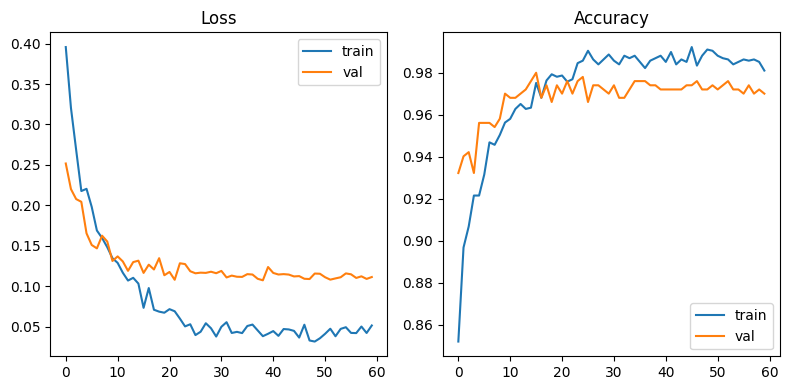

In [35]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()